# Processing DeWeirdt 2020

Here we process tiling data from [DeWeirdt et al. 2020](https://www.nature.com/articles/s41587-020-0600-6?proof=t)

### Data Filters
1. pdna or etp > mean pdna -3 std
2. Positive control genes with an ROC-AUC > 0.7 compared against cell surface control genes
3. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
import poola.core as pool
from tqdm import tqdm

In [2]:
reads = (pd.read_csv('../data/raw/DeWeirdt2020_AACC03_reads.csv')
         .drop('Gene ID', axis=1)
         .rename({'Construct Barcode': 'sgRNA Sequence'}, axis=1))

In [3]:
read_cols = ['AACC03_pDNA_1', 'AACC03_pDNA_2', 
             'A375_Dropout_Rep A', 'A375_Dropout_Rep B', 
             'MELJUSO_Dropout_Rep A', 'MELJUSO_Dropout_Rep B', 
             'HT29_Dropout_Rep A', 'HT29_Dropout_Rep B']
lognorms = pool.lognorm_columns(reads_df=reads, columns=read_cols)
pdna_cols = ['AACC03_pDNA_1', 'AACC03_pDNA_2']
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=pdna_cols, z_low=-3)
filtered_lognorms['pDNA_avg'] = filtered_lognorms[pdna_cols].mean(axis=1)
filtered_lognroms = filtered_lognorms.drop(pdna_cols, axis=1)
lognorms.shape[0] - filtered_lognorms.shape[0]

70

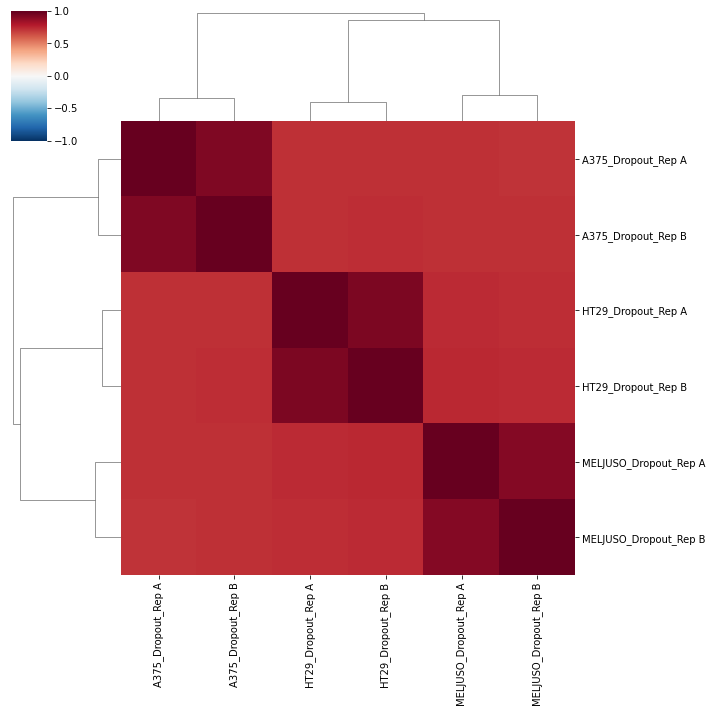

In [4]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognroms, ref_col='pDNA_avg', 
                             target_cols=['A375_Dropout_Rep A', 'A375_Dropout_Rep B', 
                                          'MELJUSO_Dropout_Rep A', 'MELJUSO_Dropout_Rep B', 
                                          'HT29_Dropout_Rep A', 'HT29_Dropout_Rep B'])
lfc_cors = lfc_df.corr()
sns.clustermap(lfc_cors, cmap='RdBu_r', vmin=-1, vmax=1)

In [5]:
sg_list = list(lfc_df['sgRNA Sequence'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [6]:
long_lfcs = pool.average_replicate_lfcs(lfcs=lfc_df, guide_col='sgRNA Sequence', 
                                        condition_indices=[0], sep = '_')
annot_guide_lfcs = pool.annotate_guide_lfcs(long_lfcs, design_df,
                                            'Target Gene Symbol', merge_on='sgRNA Sequence')

fp_genes = ['CD81', 'CD33', 'FAS', 'ICAM1']

In [7]:
essential_genes = ['EEF2', 'HNRNPU', 'PELP1', 'TFRC', 'SF3B1', 'PSMA6',
                   'KPNB1', 'SNRPD1', 'RPS20', 'POLR1C']
meljuso_genes = ['HRAS', 'NRAS', 'PEX6', 'PEX10', 'SOX10']
tp_mapping_df = pd.DataFrame({'Target Gene Symbol': essential_genes + meljuso_genes,
                              'context': ['essential']*len(essential_genes) + ['MELJUSO']*len(meljuso_genes)})


In [8]:
auc_list = []
for _, (tp, context) in tqdm(tp_mapping_df.iterrows()):
    if context == 'essential':
        conditions = ['A375', 'MELJUSO', 'HT29']
    else:
        conditions = [context]
    context_guide_lfcs = annot_guide_lfcs[annot_guide_lfcs.condition.isin(conditions)]
    auc_df, _ = pool.get_roc_aucs(lfcs=context_guide_lfcs, tp_genes=[tp],
                                  fp_genes=fp_genes, gene_col='Target Gene Symbol',
                                  score_col='avg_lfc', condition_col=['condition'])
    auc_df['Target Gene Symbol'] = tp
    auc_list.append(auc_df)
concat_auc_df = (pd.concat(auc_list)
                 .reset_index(drop=True))
filtered_auc_df = concat_auc_df.query("`ROC-AUC` > 0.7")

15it [00:00, 30.89it/s]


In [9]:
relevant_sgs_designs = annot_guide_lfcs.merge(filtered_auc_df, how='inner',
                                              on=['Target Gene Symbol', 'condition'])
filtered_sgs = relevant_sgs_designs[(relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0')].copy()
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                             .avg_lfc
                             .rank(pct=True, ascending=False))
sg_avg_rank = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                     'Target Cut %', 'On-Target Efficacy Score'])
               .agg(avg_rank = ('gene_rank', 'mean'))
               .reset_index())

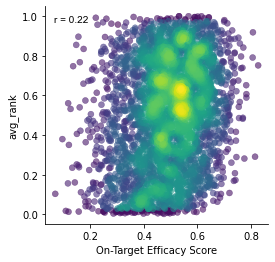

In [10]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=sg_avg_rank, y='avg_rank', x='On-Target Efficacy Score')
gpplot.add_correlation(data=sg_avg_rank, y='avg_rank', x='On-Target Efficacy Score')
sns.despine()

In [11]:
training_data = sg_avg_rank.drop('On-Target Efficacy Score', axis=1)
training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,avg_rank
0,AAAAAATTATGCTGAATACC,GATTAAAAAATTATGCTGAATACCAGGTAG,KPNB1,75.6,0.332121
1,AAAACAGGGGCACGAGGGTA,AGGAAAAACAGGGGCACGAGGGTATGGATA,HNRNPU,91.0,0.461071
2,AAAACCGGCGCTGGAACCAC,GGTCAAAACCGGCGCTGGAACCACGGGACA,PSMA6,1.3,0.261905
3,AAAACTATCAAGTTGGGATC,CCAAAAAACTATCAAGTTGGGATCAGGCAG,SF3B1,16.7,0.302181
4,AAAACTCTTGGAGCAATATA,CCCAAAAACTCTTGGAGCAATATAAGGAAG,HNRNPU,80.5,0.846715
...,...,...,...,...,...
3505,TTTGGCCTCACCACACTTGC,CTACTTTGGCCTCACCACACTTGCAGGTAG,PEX10,19.2,0.796954
3506,TTTGTATATAAATGCCTTAC,ATCTTTTGTATATAAATGCCTTACTGGGAT,HNRNPU,40.5,0.886861
3507,TTTGTCCAGGAAGTTGTCCA,ACAATTTGTCCAGGAAGTTGTCCAGGGCAG,EEF2,99.1,0.134318
3508,TTTGTCTCCTCCAGGCCTGG,GCAGTTTGTCTCCTCCAGGCCTGGAGGCCT,PEX6,44.6,0.548214


In [12]:
training_data.to_csv('../data/processed/DeWeirdt2020_activity.csv', index=False)